In [37]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister, execute, Aer, IBMQ,BasicAer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import math
import matplotlib.pyplot as plt
from random import *

In [12]:
#permet de construire les entreés du circuit 
#et calcul le nombre de bit auxiliaire recquis

def buildPlainAdder(numberOfQubits):
    
    
    #Definition of the registers
    
    A = QuantumRegister(numberOfQubits,"a")
    circ_A=QuantumCircuit(A)
    B = QuantumRegister(numberOfQubits,"b")
    circ_B=QuantumCircuit(B)
    Cout = QuantumRegister(1,"cout")
    #Anc=QuantumRegister(1,"anc")
    C = QuantumRegister(numberOfQubits,"c")
    circ_C=QuantumCircuit(C,Cout)

    
    Adder = circ_A+circ_B+circ_C
    
    
    #compute g[i,i+1] into auxillary register for 0<i<n
    for i in range(0,numberOfQubits-1):
        Adder.ccx(A[i],B[i],C[i+1])
        
    Adder.ccx(A[numberOfQubits-1],B[numberOfQubits-1],Cout[0])
    
        
    Adder.barrier()    
    #compute p[i,i+1] into b register for 0<i<n
    for i in range(0,numberOfQubits):
        Adder.cx(A[i],B[i])
        
    
    Adder.barrier()
    

    for i in range(0,numberOfQubits-1):
        Adder.ccx(C[i],B[i],C[i+1])
    
    Adder.ccx(C[numberOfQubits-1],B[numberOfQubits-1],Cout[0])

    
    Adder.barrier()
    
    for i in range(0,numberOfQubits):
        Adder.cx(C[i],B[i])    
    
    Adder.barrier()
    
    
    for i in range(numberOfQubits-2,-1,-1):
        Adder.ccx(C[i],B[i],C[i+1])
        
    Adder.barrier()
    
    
    #compute g[i,i+1] into auxillary register for 0<i<n
    for i in range(numberOfQubits-2,-1,-1):
        Adder.ccx(A[i],B[i],C[i+1])
        
        
    #ajout d'un registre classique pour mesurer l'état des bits
    outB = ClassicalRegister(numberOfQubits,"outB")
    outC = ClassicalRegister(1,"outC")
    #ajout du circuit de mesure
    meas = QuantumCircuit(B,outB,Cout,outC)
    meas.barrier(B)
    meas.barrier(Cout)
    meas.measure(B,outB)  #mesure la valeur de q et la place dans c
    meas.measure(Cout,outC)
    qc = Adder + meas   #ajoute le circuit de mesure à la suite de circ (le circuit avec les portes quantiques)
    
    return qc

In [13]:
#calcul le nombre de 1 dans la représentation binaire du nombre de qubit
def countOnes(numberOfQubits):
    counts = 0
    while numberOfQubits!=0:
        numberOfQubits=numberOfQubits&(numberOfQubits-1)
        counts=counts+1
    return counts

In [14]:
#permet de construire les entreés du circuit 
#et calcul le nombre de bit auxiliaire recquis

def buildCarryLookAheadAdder(numberOfQubits):
    
    #useful constant
    logn=math.floor(math.log(numberOfQubits,2))
    log2_3n=math.floor(math.log((2/3)*numberOfQubits,2))
    
    
    n_auxillaryQubits=numberOfQubits-countOnes(numberOfQubits)-logn
    
    if(n_auxillaryQubits<=0):
        n_auxillaryQubits=1
    
    
    #Definition of the registers

    # These registers contains the numbers to add
    A = QuantumRegister(numberOfQubits,"a")
    circ_A=QuantumCircuit(A)
    B = QuantumRegister(numberOfQubits,"b")
    circ_B=QuantumCircuit(B)
    #Sum register
    S=QuantumRegister(numberOfQubits+1,"s")
    #Ancillary register
    Anc=QuantumRegister(n_auxillaryQubits,"anc")
    circ_S=QuantumCircuit(S,Anc)
    
    
    Adder = circ_A+circ_B+circ_S
    
    
    #compute g[i,i+1] into auxillary register for 0<i<n
    for i in range(0,numberOfQubits):
        Adder.ccx(A[i],B[i],S[i+1])
        
    Adder.barrier()    
    #compute p[i,i+1] into b register for 0<i<n
    for i in range(1,numberOfQubits):
        Adder.cx(A[i],B[i])
    
    Adder.barrier()
    

    boundList=[]
    roundUpperBound=1
    boundList.append(roundUpperBound)
    #P-round
    for t in range(1,logn):
        tmp=math.pow(2,t)
        roundUpperBound = math.floor(numberOfQubits/(tmp))
        if t>1:
            boundList.append(roundUpperBound+boundList[t-1]-1)
        else:
            boundList.append(roundUpperBound)
        for m in range(1,roundUpperBound):
            if t>1:
                Adder.ccx(Anc[2*m-1],Anc[2*m],Anc[m+boundList[t-1]-2])
            else:
                Adder.ccx(B[2*m],B[2*m+1],Anc[m-1])
            
    Adder.barrier()
    
    
    
    #G-round
    for t in range(1,logn+1):
        tmp=int(math.pow(2,t))
        tmp1=int(math.pow(2,t-1))
        roundUpperBound = math.floor(numberOfQubits/(tmp))
        for m in range(0,roundUpperBound):
            if t>1:
                Adder.ccx(S[tmp*m+tmp1],Anc[2*m+boundList[t-2]-1],S[tmp*m+tmp])
            else:
                Adder.ccx(S[tmp*m+tmp1],B[2*m+1],S[tmp*m+tmp])
    Adder.barrier()
    
              
    #C-round
    for t in range(log2_3n,0,-1):
        tmp=int(math.pow(2,t))
        tmp1=int(math.pow(2,t-1))
        roundUpperBound=math.floor((numberOfQubits-tmp1)/tmp)
        for m in range (1,roundUpperBound+1):
            if t>1:
                Adder.ccx(S[tmp*m],Anc[2*m+boundList[t-2]-2],S[tmp*m+tmp1])
            else:
                Adder.ccx(S[tmp*m],B[2*m],S[tmp*m+tmp1])
    
    Adder.barrier()
    
    #P(-1)-round
    for t in range(logn-1,0,-1):
        tmp=math.pow(2,t)
        roundUpperBound = math.floor(numberOfQubits/(tmp))
        for m in range(1,roundUpperBound):
            if t>1:
                Adder.ccx(Anc[2*m-1],Anc[2*m],Anc[m+boundList[t-1]-2])
            else:
                Adder.ccx(B[2*m],B[2*m+1],Anc[m-1])
                
    Adder.barrier()
    
    for i in range(0,numberOfQubits):
        Adder.cx(B[i],S[i])
    
    Adder.barrier()
    
    Adder.cx(A[0],S[0])
    
    for i in range(1,numberOfQubits):
        Adder.cx(A[i],B[i])
        
        
    #adding a  Register to measure the state of the qubits
    outS = ClassicalRegister(numberOfQubits+1,"outS")

    #adding measure circuit
    meas = QuantumCircuit(S,outS)
    meas.barrier(S)
    meas.measure(S,outS)  #measur S values into outS
    qc = Adder + meas   #concatenate the circuit
    
    return qc

In [21]:
def buildModCarryLookAheadAdder(numberOfQubits):
    
    logn=math.floor(math.log(numberOfQubits,2))
    log2_3n=math.floor(math.log((2/3)*numberOfQubits,2))
    nP_round1=math.floor(numberOfQubits/2)-1
    stateVectorSize=int(math.pow(2,numberOfQubits))
    #Definition of the registers
    
    n_auxillaryQubits=numberOfQubits-countOnes(numberOfQubits)-logn-nP_round1
    
    
    A = QuantumRegister(numberOfQubits,"a")
    circ_A=QuantumCircuit(A)
    B = QuantumRegister(numberOfQubits,"b")
    circ_B=QuantumCircuit(B)
    S=QuantumRegister(numberOfQubits+1,"s")
    if(n_auxillaryQubits>0):
        Anc=QuantumRegister(n_auxillaryQubits,"anc")
        circ_S=QuantumCircuit(S,Anc)
    else:
        circ_S=QuantumCircuit(S)
    
    Adder = circ_A+circ_B+circ_S
    
    
    
    #Utility list
    Buffer=[]  #on y place les P successifs
    Buffer_Anc_list=[]
    P_list=[]
    precompute_list=[]     #On peut s'en passer aussi
    P_inv_list=[]
    Anc_list=[]
    
    #Precomputation for uncomputation before Prounds
    #On calcule les indices  auquelles on va
    #stocker la valeur des P-round1 pour pouvoir 
    #prévoir ou placer les cx de P0
    roundUpperBound = math.floor(numberOfQubits/2)         #Inutile on peut s'en servir juste à P0 pour 
    #prévoir ou mettre les cx
    for m in range(1,roundUpperBound):
        precompute_list.append(2*m+1)
                

    #compute g[i,i+1] into auxillary register for 0<i<n
    #G0 round
    for i in range(0,numberOfQubits):
        Adder.ccx(A[i],B[i],S[i+1])

        
    
        
    #Adder.barrier()    
    #compute p[i,i+1] into b register for 0<i<n
    #P0 round
    for i in range(1,numberOfQubits):
        if(i+1 not in precompute_list):
            #On ne place pas de cnot aux endroits ou on va devoir uncompute
            Adder.cx(A[i],B[i])
             
    
    #Adder.barrier()
    i=0
    for t in range(1,logn+1):
        tmp=int(math.pow(2,t))
        tmp1=int(math.pow(2,t-1))
        roundUpperBound = math.floor(numberOfQubits/(tmp))
        #G-round
        #On effectue alterne les rounds entre G-round et P-round
        for m in range(0,roundUpperBound):
            if(t==1):
                #1er round on utilise la formule classique
                Adder.ccx(S[tmp*m+tmp1],B[2*m+1],S[tmp*m+tmp])
            else:
                #Pour les rounds suivant on utilise 
                Adder.ccx(S[tmp*m+tmp1],P_list[t-2][2*m],S[tmp*m+tmp])
        #Adder.barrier()
        #P-round
        for m in range(1,roundUpperBound):
            if(t==1):
                #Uncompute previous operation
                #On doit d'abord uncompute les opérations de g0
                
                #Uncomputation
                Adder.ccx(A[2*m],B[2*m],S[2*m+1])                
                Adder.cx(A[2*m],B[2*m])  
                ###################################
                
                Adder.ccx(B[2*m],B[2*m+1],S[2*m+1])
                Buffer.append(S[2*m+1])
                P_inv_list.append([B[2*m],B[2*m+1],S[2*m+1]])       #Enregistre toutes les opérations à uncompute
            else:
                Adder.ccx(P_list[t-2][2*m-1],P_list[t-2][2*m],Anc[i])
                Buffer.append(Anc[i])
                Buffer_Anc_list.append([P_list[t-2][2*m-1],P_list[t-2][2*m],Anc[i]])
                i=i+1
        P_list.append(Buffer)
        if(t>1):
            Anc_list.append(Buffer_Anc_list)
            Buffer_Anc_list=[]
        Buffer=[]
        #Adder.barrier()
    
    
    #C-round/P1 uncompute/Recompute
    for t in range(log2_3n,0,-1):
        tmp=int(math.pow(2,t))
        tmp1=int(math.pow(2,t-1))
        roundUpperBound=math.floor((numberOfQubits-tmp1)/tmp)
        if(t==1):
            #si t==1 alors on uncompute tous les P1 et recompute P0,G0
            #pour pouvoir mettre les C1
            for i in range(1,len(P_inv_list)+1):
                Adder.ccx(P_inv_list[i-1][0],P_inv_list[i-1][1],P_inv_list[i-1][2])  #Uncompute les P1
                Adder.cx(A[tmp*i+tmp1-1],B[tmp*i+tmp1-1])
                Adder.ccx(A[tmp*i+tmp1-1],B[tmp*i+tmp1-1],S[tmp*i+tmp1])
                Adder.cx(A[tmp*i+tmp1-1],B[tmp*i+tmp1-1]) 
        else:
            for k in range(0,len(Anc_list[t-2])):
                Adder.ccx(Anc_list[t-2][k][0],Anc_list[t-2][k][1],Anc_list[t-2][k][2])
        for m in range (1,roundUpperBound+1):
            if t>1:
                Adder.ccx(S[tmp*m],P_list[t-2][2*m-1],S[tmp*m+tmp1])
            else:
                Adder.ccx(S[tmp*m],B[2*m],S[tmp*m+tmp1])
    
    #Adder.barrier()
    

    #Adder.barrier()
    #compute sum
    for i in range(0,numberOfQubits):
        Adder.cx(B[i],S[i])
    Adder.cx(A[0],S[0])
    
    #Adder.barrier()
    #uncompute b
    for i in range(1,numberOfQubits):
        Adder.cx(A[i],B[i])
     
    #Adder.barrier()
    
    #adding a  Register to measure the state of the qubits
    outS = ClassicalRegister(numberOfQubits+1,"outS")

    #adding measure circuit
    meas = QuantumCircuit(S,outS)
    meas.barrier(S)
    meas.measure(S,outS)  #measur S values into outS
    qc = Adder + meas   #concatenate the circuit
    
    
    return qc

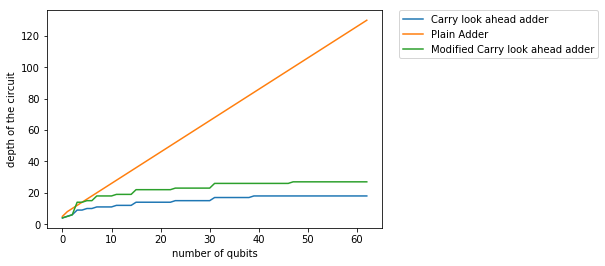

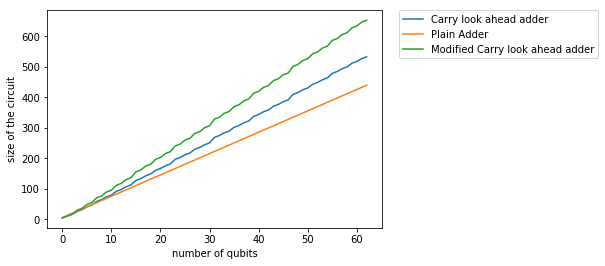

In [40]:
tabDepthCarrylokkAhead=[]
tabDepthPlain=[]
tabModDepthCarrylokkAhead=[]
tabSizeCarrylokkAhead=[]
tabSizePlain=[]
tabSizeModCarrylokkAhead=[]
for i in range(1,64):
    carryLookAheadAdder = buildCarryLookAheadAdder(i)
    plainAdder = buildPlainAdder(i)
    modCarryLookAheadAdder=buildModCarryLookAheadAdder(i)
    d1=carryLookAheadAdder.depth()
    d2=plainAdder.depth()
    d3=modCarryLookAheadAdder.depth()
    s1=carryLookAheadAdder.size()
    s2=plainAdder.size()
    s3=modCarryLookAheadAdder.size()
    tabDepthCarrylokkAhead.append(d1)
    tabDepthPlain.append(d2)
    tabModDepthCarrylokkAhead.append(d3)
    tabSizeCarrylokkAhead.append(s1)
    tabSizePlain.append(s2)
    tabSizeModCarrylokkAhead.append(s3)

plt.plot(tabDepthCarrylokkAhead,label='Carry look ahead adder')
plt.plot(tabDepthPlain,label="Plain Adder")
plt.plot(tabModDepthCarrylokkAhead,label='Modified Carry look ahead adder')
plt.ylabel('depth of the circuit')
plt.xlabel('number of qubits')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.plot(tabSizeCarrylokkAhead,label='Carry look ahead adder')
plt.plot(tabSizePlain,label="Plain Adder")
plt.plot(tabSizeModCarrylokkAhead,label='Modified Carry look ahead adder')
plt.ylabel('size of the circuit')
plt.xlabel('number of qubits')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()
plt.show()

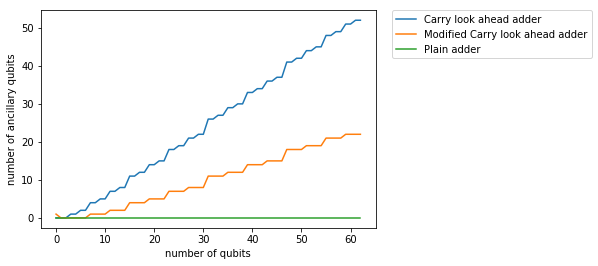

In [42]:
tabAuxillaryQubits=[]
tabAuxillaryQubitsBis=[]
for i in range(1,64):
    logn=math.floor(math.log(i,2))
    nP_round1=math.floor(i/2)-1
    n_auxillaryQubits=i-countOnes(i)-logn
    n_auxillaryQubitsBis=i-countOnes(i)-logn-nP_round1
    tabAuxillaryQubits.append(n_auxillaryQubits)
    tabAuxillaryQubitsBis.append(n_auxillaryQubitsBis)


plt.plot(tabAuxillaryQubits,label='Carry look ahead adder')
plt.plot(tabAuxillaryQubitsBis,label='Modified Carry look ahead adder')
plt.plot([0]*63,label='Plain adder')
plt.ylabel('number of ancillary qubits')
plt.xlabel('number of qubits')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [32]:
A=buildModCarryLookAheadAdder(30)
A.size()

301

In [33]:
B=buildCarryLookAheadAdder(30)
B.size()

245

In [34]:
C=buildPlainAdder(30)
C.size()

209